<a href="https://www.kaggle.com/code/ajbotticelli/wildfire-prediction?scriptVersionId=141183146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Wildfire Detection DS420
### Authors: Aj Botticelli & Yusuke Satani
### Date: Spring 2023
### Goal: Using satellite image data from Kaggle (from the Canadian Govt), predict wildfire occurances in a model integrated with spark for real-time parsing
Based from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

https://towardsdatascience.com/how-to-train-your-neural-networks-in-parallel-with-keras-and-apache-spark-ea8a3f48cae6

https://towardsdatascience.com/deep-learning-with-apache-spark-part-2-2a2938a36d35

https://github.com/HDFGroup/hdf5-spark-connector

https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

# Imports & Pathfinding

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

from PIL import ImageFile

In [2]:
pathTrain = "../input/wildfire-prediction-dataset/train"
pathVal = "../input/wildfire-prediction-dataset/valid"
pathTest = "../input/wildfire-prediction-dataset/test"

# Offline Model: Base CNN

## Preproccessing

In [3]:
trainDatagen = ImageDataGenerator(rescale=1./255)
testDatagen = ImageDataGenerator(rescale=1./255)
validationDatagen = ImageDataGenerator(rescale=1./255)

In [4]:
#Target size chosen arbitrarily along with batch size
trainIter = trainDatagen.flow_from_directory(
    pathTrain,
    target_size=(256, 256),
    batch_size=16
)

Found 30250 images belonging to 2 classes.


In [5]:
testIter = testDatagen.flow_from_directory(
    pathTest,
    target_size=(256, 256),
    batch_size=16
)

Found 6300 images belonging to 2 classes.


In [6]:
validIter = validationDatagen.flow_from_directory(
    pathVal,
    target_size=(256, 256),
    batch_size=16
)

Found 6300 images belonging to 2 classes.


In [7]:
#the elements in each category
from collections import Counter
counter = Counter(trainIter.classes)
print(counter.items())

dict_items([(0, 14500), (1, 15750)])


In [8]:
trainIter.reset() 

batchX, batchy = trainIter.next()
print("Batch shape of X = " + str(batchX.shape) + ", Xmin = "+str(batchX.min()) + ", Xmax = "+str(batchX.max()))
print("Batch shape of Y = " + str(batchy.shape) + ", ymin = "+str(batchy.min()) + ", ymax = "+str(batchy.max()))

Batch shape of X = (16, 256, 256, 3), Xmin = 0.0, Xmax = 1.0
Batch shape of Y = (16, 2), ymin = 0.0, ymax = 1.0


In [9]:
print(trainIter.class_indices)

{'nowildfire': 0, 'wildfire': 1}


## Modeling
-Using first a simple self made CNN

-Then using a CNN following AlexNet structure

In [10]:
# Dimensions of our images.
img_width, img_height = 256, 256 
input_shape = (img_width, img_height, 3) # each image has 3 channels

# Epochs
epochsAmt = 10

# Number of images to read every iteration 
batch_size = 64

# Total number of images for training and testing
train_num = 30250 
test_num = 6300 
valid_num = 6300 

# Total number of steps in each epoch
train_steps = train_num // batch_size # integer division
test_steps  = test_num  // batch_size 

# Total number of classes
num_classes = 2


In [11]:
model = keras.Sequential(name = 'Wildfire-CNN')

model.add(layers.Conv2D(8, kernel_size = (3,3),activation = 'relu', input_shape = input_shape))

model.add(layers.Conv2D(16, kernel_size = (3,3),activation = 'relu'))

model.add(layers.MaxPooling2D(pool_size = (2,2)))

model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(32,activation = 'relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(2,activation = 'softmax'))

model.summary()

Model: "Wildfire-CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 16)      1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 16)      0         
                                                                 
 flatten (Flatten)           (None, 254016)            0         
                                                                 
 dense (Dense)               (None, 32)                8128544   
                                                      

In [12]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2=0.999)
model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [13]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = history = model.fit(trainIter,
                    batch_size=batch_size,
                    epochs=epochsAmt,
                    validation_data=(validIter),
                    steps_per_epoch = train_steps,
                    validation_steps = test_steps)

Epoch 1/10


2023-08-27 18:25:19.582918: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inWildfire-CNN/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


472/472 [==============================] - 69s 129ms/step - loss: 0.4373 - accuracy: 0.8703 - val_loss: 0.2359 - val_accuracy: 0.9171
Epoch 2/10
472/472 [==============================] - 55s 116ms/step - loss: 0.2581 - accuracy: 0.9173 - val_loss: 0.1810 - val_accuracy: 0.9407
Epoch 3/10
472/472 [==============================] - 52s 110ms/step - loss: 0.2247 - accuracy: 0.9251 - val_loss: 0.3191 - val_accuracy: 0.9126
Epoch 4/10
472/472 [==============================] - 52s 110ms/step - loss: 0.2040 - accuracy: 0.9325 - val_loss: 0.1818 - val_accuracy: 0.9407
Epoch 5/10
472/472 [==============================] - 45s 96ms/step - loss: 0.1884 - accuracy: 0.9372 - val_loss: 0.1493 - val_accuracy: 0.9407
Epoch 6/10
472/472 [==============================] - 48s 102ms/step - loss: 0.1751 - accuracy: 0.9431 - val_loss: 0.1377 - val_accuracy: 0.9560
Epoch 7/10
472/472 [==============================] - 44s 93ms/step - loss: 0.1754 - accuracy: 0.9364 - val_loss: 0.1634 - val_accuracy: 0.937

In [14]:
result = model.evaluate(testIter)

394/394 [==============================] - 41s 104ms/step - loss: 0.1706 - accuracy: 0.9537


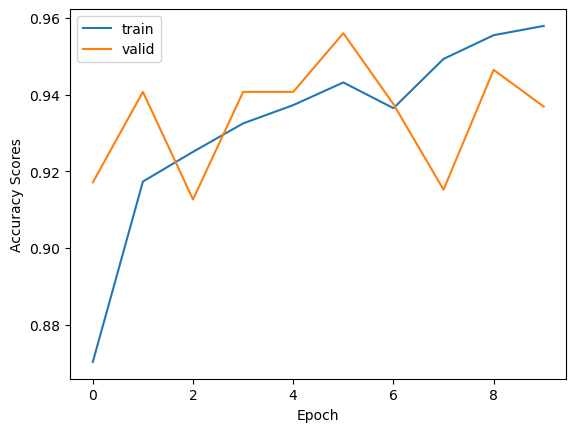

In [15]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'valid')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy Scores')

plt.show()

In [16]:
testIter.reset() 
images, labels =  testIter.next()
y_pred = model.predict(images)


1/1 [==============================] - 0s 131ms/step


In [17]:
y_pred

array([[1.0000000e+00, 1.5901460e-14],
       [9.9999809e-01, 1.8728963e-06],
       [1.3927216e-02, 9.8607278e-01],
       [1.7795404e-02, 9.8220462e-01],
       [1.0062891e-01, 8.9937115e-01],
       [9.9999833e-01, 1.6229961e-06],
       [1.3982368e-01, 8.6017632e-01],
       [2.2277195e-02, 9.7772276e-01],
       [1.2427659e-02, 9.8757231e-01],
       [9.9580836e-01, 4.1916859e-03],
       [1.0000000e+00, 8.1543511e-17],
       [1.0000000e+00, 1.2529949e-22],
       [3.3168849e-02, 9.6683115e-01],
       [9.9999869e-01, 1.3559676e-06],
       [1.0000000e+00, 6.9387024e-11],
       [7.2077505e-02, 9.2792255e-01]], dtype=float32)

In [18]:
y_pred[1].argmax()

0

In [19]:
labels

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [20]:
labels[1].argmax()

0

1/1 [==============================] - 0s 27ms/step


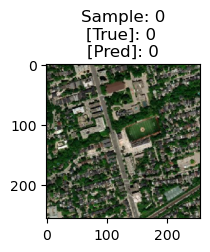

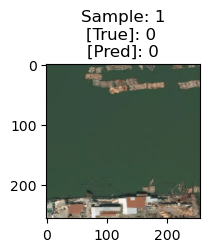

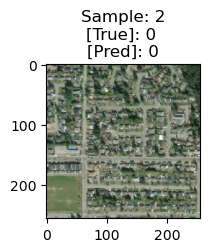

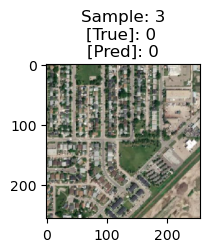

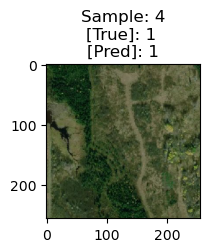

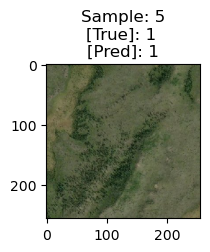

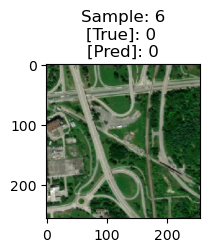

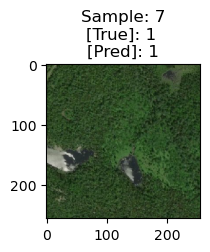

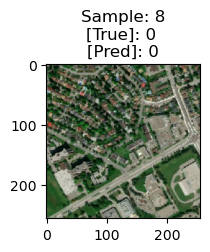

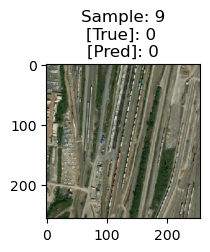

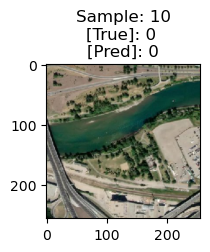

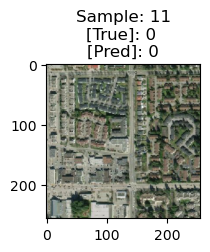

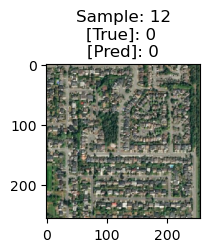

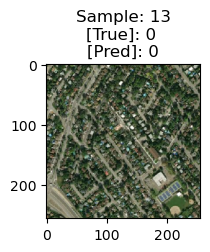

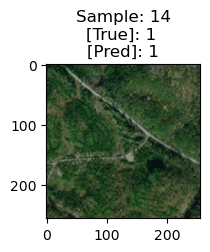

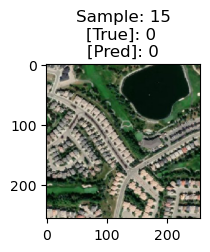

In [21]:
testIter.reset() 
images, labels =  testIter.next()
y_pred = model.predict(images)

for idx, img in enumerate(images):
    plt.figure(figsize = (2, 2))
    pred_label=str(y_pred[idx].argmax())
    true_label=str(labels[idx].argmax())
    plt.title('Sample: '+str(idx) + "\n[True]: "+true_label + " \n[Pred]: "+ pred_label)
    plt.imshow(img)
    plt.show()


Old Code

y_pred = model.predict(testIter)
testIter.reset() 
images, labels =  testIter.next()

for idx, img in enumerate(images):
    plt.figure(figsize = (2, 2))
    pred_label=str(y_pred[idx].argmax())
    true_label=str(y_pred.argmax())
    if(pred_label!= true_label):
        plt.title('Sample: '+str(idx) + "\n[True]: "+true_label + " \n[Pred]: "+ pred_label)
        plt.imshow(img)
        plt.show()


# Offline Model: AlexNet CNN

## Preproccessing

In [22]:
trainDatagen = ImageDataGenerator(rescale=1./227) #May need to rescale to 255
testDatagen = ImageDataGenerator(rescale=1./227)
validationDatagen = ImageDataGenerator(rescale=1./227)

In [23]:
trainIter = trainDatagen.flow_from_directory(
    pathTrain,
    target_size=(227, 227),
    batch_size=32 #Tune this parameter
)

Found 30250 images belonging to 2 classes.


In [24]:
testIter = testDatagen.flow_from_directory(
    pathTest,
    target_size=(227, 227),
    batch_size=32
)

Found 6300 images belonging to 2 classes.


In [25]:
validIter = validationDatagen.flow_from_directory(
    pathVal,
    target_size=(227, 227),
    batch_size=32
)

Found 6300 images belonging to 2 classes.


In [26]:
#the elements in each category
from collections import Counter
counter = Counter(trainIter.classes)
print(counter.items())

dict_items([(0, 14500), (1, 15750)])


In [27]:
trainIter.reset() 

batchX, batchy = trainIter.next()
print("Batch shape of X = " + str(batchX.shape) + ", Xmin = "+str(batchX.min()) + ", Xmax = "+str(batchX.max()))
print("Batch shape of Y = " + str(batchy.shape) + ", ymin = "+str(batchy.min()) + ", ymax = "+str(batchy.max()))

Batch shape of X = (32, 227, 227, 3), Xmin = 0.0, Xmax = 1.123348
Batch shape of Y = (32, 2), ymin = 0.0, ymax = 1.0


In [28]:
print(trainIter.class_indices)

{'nowildfire': 0, 'wildfire': 1}


### AlexNet Model

In [29]:
# Dimensions of our images.
img_width, img_height = 227, 227 
input_shape = (img_width, img_height, 3) # each image has 3 channels

# Epochs
epochsAmt = 10

# Number of images to read every iteration 
batch_size = 32 #Tune this Parameter

# Total number of images for training and testing
train_num = 30250 
test_num = 6300 
valid_num = 6300 

# Total number of steps in each epoch
train_steps = train_num // batch_size # integer division
test_steps  = test_num  // batch_size 

# Total number of classes
num_classes = 2

In [30]:
model = keras.Sequential(name = 'Wildfire-AlexNet')

model.add(layers.Conv2D(filters = 96, kernel_size = (11,11), strides = (4,4), activation = 'relu', input_shape = input_shape))

model.add(layers.MaxPooling2D(pool_size = (3,3), strides = (2,2)))

model.add(layers.Conv2D(filters = 256, kernel_size = (5,5), strides = (1,1), activation = 'relu', padding = 'same'))

model.add(layers.MaxPooling2D(pool_size = (3,3), strides = (2,2)))

model.add(layers.Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))

model.add(layers.Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))

model.add(layers.Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), activation = 'relu', padding = 'same'))

model.add(layers.MaxPooling2D(pool_size = (3,3), strides = (2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(4096, activation = 'relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(4096, activation = 'relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(2, activation = 'softmax'))

model.summary()

Model: "Wildfire-AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 384)  

In [31]:
model.compile(optimizer = tf.optimizers.SGD(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "Wildfire-AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 384)  

In [32]:
ImageFile.LOAD_TRUNCATED_IMAGES = True #About 40 Minutes Per epoch

history =  model.fit(trainIter,
                    batch_size=batch_size,
                    epochs=epochsAmt,
                    validation_data=(validIter),
                    steps_per_epoch = train_steps,
                    validation_steps = test_steps)

Epoch 1/10
945/945 [==============================] - 170s 178ms/step - loss: 0.3672 - accuracy: 0.8298 - val_loss: 0.2278 - val_accuracy: 0.9096
Epoch 2/10
945/945 [==============================] - 170s 179ms/step - loss: 0.2454 - accuracy: 0.9004 - val_loss: 0.2508 - val_accuracy: 0.8967
Epoch 3/10
945/945 [==============================] - 160s 169ms/step - loss: 0.2233 - accuracy: 0.9126 - val_loss: 0.2100 - val_accuracy: 0.9142
Epoch 4/10
945/945 [==============================] - 155s 164ms/step - loss: 0.2033 - accuracy: 0.9219 - val_loss: 0.1590 - val_accuracy: 0.9354
Epoch 5/10
945/945 [==============================] - 171s 181ms/step - loss: 0.1807 - accuracy: 0.9313 - val_loss: 0.1477 - val_accuracy: 0.9448
Epoch 6/10
945/945 [==============================] - 170s 180ms/step - loss: 0.1694 - accuracy: 0.9348 - val_loss: 0.1246 - val_accuracy: 0.9546
Epoch 7/10
945/945 [==============================] - 167s 177ms/step - loss: 0.1575 - accuracy: 0.9391 - val_loss: 0.1200 -

In [33]:
result = model.evaluate(testIter)

197/197 [==============================] - 29s 146ms/step - loss: 0.1015 - accuracy: 0.9595


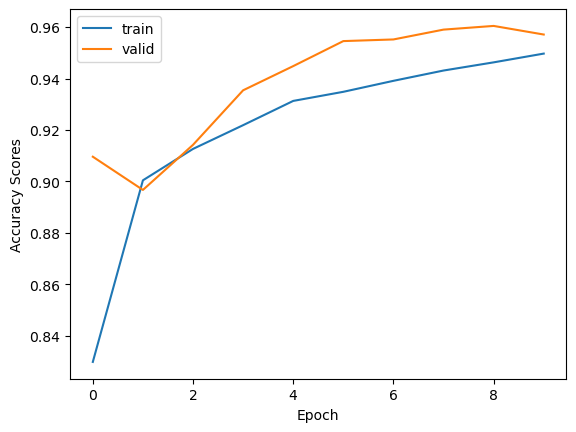

In [34]:
plt.plot(history.history['accuracy'], label = 'train',)
plt.plot(history.history['val_accuracy'], label = 'valid')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy Scores')

plt.show()

1/1 [==============================] - 0s 124ms/step


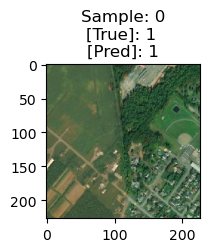

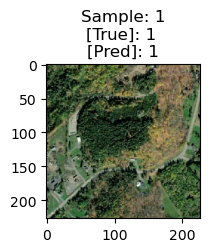

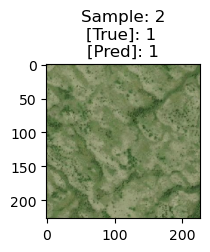

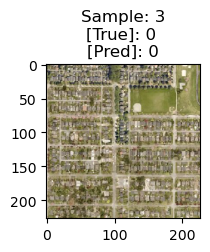

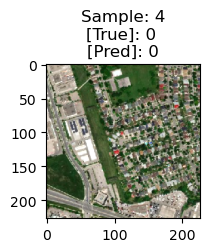

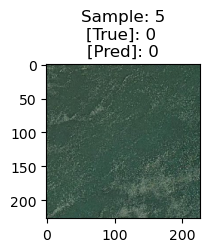

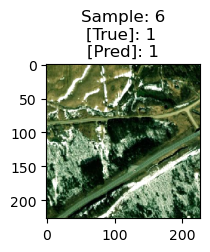

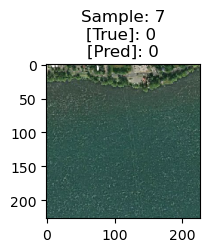

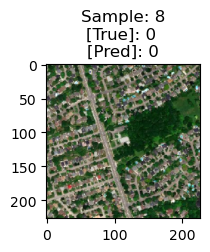

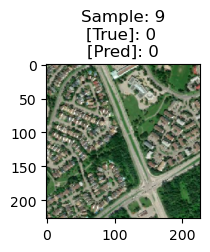

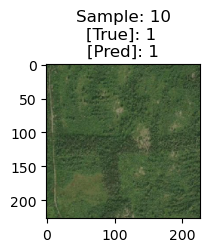

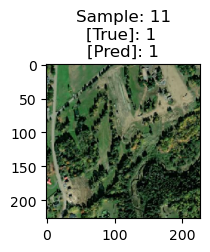

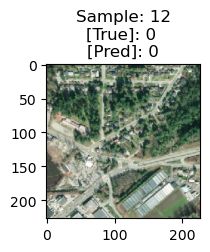

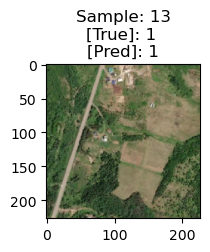

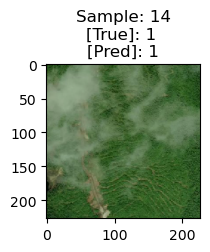

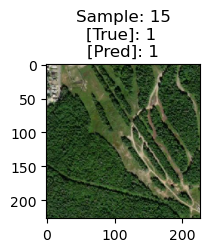

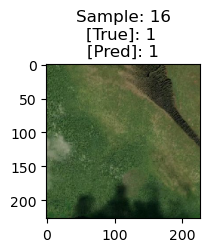

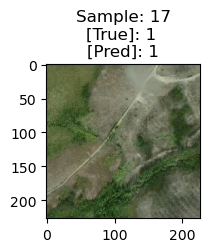

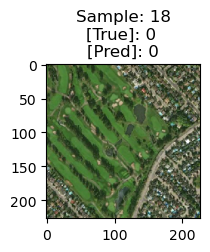

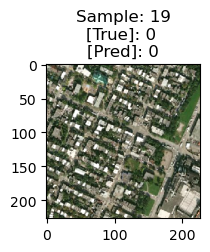

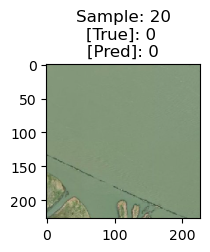

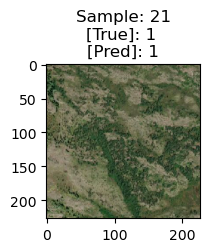

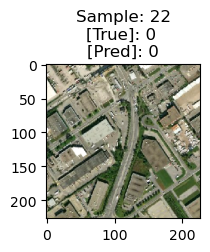

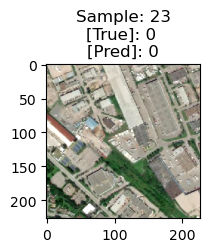

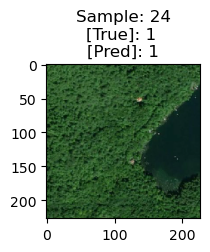

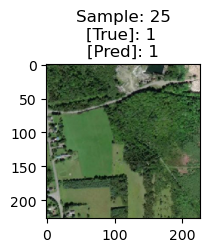

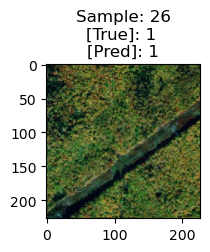

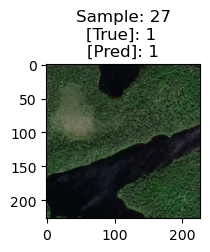

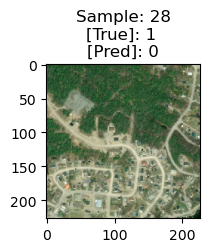

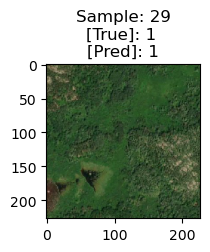

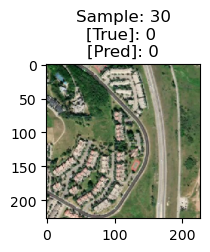

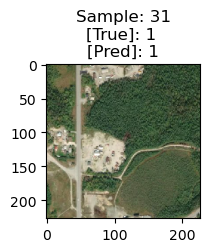

In [35]:
testIter.reset() 
images, labels =  testIter.next()
y_pred = model.predict(images)

for idx, img in enumerate(images):
    plt.figure(figsize = (2, 2))
    pred_label=str(y_pred[idx].argmax())
    true_label=str(labels[idx].argmax())
    plt.title('Sample: '+str(idx) + "\n[True]: "+true_label + " \n[Pred]: "+ pred_label)
    plt.imshow(img)
    plt.show()
